In [1]:
import pandas as pd
from os.path import join

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = "{:.2f}".format

from bokeh.models import HoverTool
from bokeh.plotting import figure, ColumnDataSource, output_notebook, show

from preprocess import get_dataset, dataset_to_X_y
from metrics import score_regression, regression_scorer
from utils import *

First let's define several useful function that we will use in this notebook
---

In [2]:
def bar(x_values, columns, title, figsize=(15,15), ax=None, get_cols=False):
    args_sorted = np.argsort(x_values)[::-1]

    fig = plt.figure(figsize=(figsize))
    ax = ax or plt.gca()
    ax.set_title(title)
    col = columns[args_sorted].astype(str)
    val = x_values[args_sorted]
    out = sns.barplot(y=col, x=val, palette=CMAP+"_r", ax=ax)
    if get_cols:
        return fig, col
    return fig


def _plot_sfs(sfs, title, with_df=False, taken_slice=None):
    metric_df = pd.DataFrame(sfs.get_metric_dict()).T
    metric_df.drop("cv_scores", axis=1, inplace=True)

    if taken_slice is not None:
        metric_df = metric_df.iloc[taken_slice]
    
    p = figure(title=title, toolbar_location="above")
    source = ColumnDataSource(metric_df)
    p.line(x="index", y="avg_score", line_color="#FF00FF", line_alpha=.6, line_width=6,source=source)
    p.dot(x="index", y="avg_score", size=24, fill_color = "yellow", source=source) 

    p.add_tools(
        HoverTool(
            tooltips=[
                ("value","@avg_score"),
                ("n_features","@index"),
                #("","@feature_names")
            ],
        )
    )

    if with_df:
        return p, metric_df

    return p

def append_fs_score(name, scores, columns):
    global FS_SCORE_PATH
    #scores = (scores - scores.min()) / scores.max()
    in_df = pd.read_csv(FS_SCORE_PATH, index_col=0)
    app_df = pd.DataFrame({c:s for c,s in zip(columns, scores)}, index=[name])
    in_df.update(app_df)
    in_df.to_csv(FS_SCORE_PATH)
    return in_df


Let's now import all data from the `preprocess` file
---

- import data into a single dict
- get the `X_train`, `y_train` needed for inference

In [4]:

dataset = get_dataset(train_size=1., seed=42)
X_train, y_train = dataset_to_X_y(dataset, keys=['train'], datatype="df")
all = pd.concat([X_train, y_train], axis=1)

X_train_num = sort_df_features(X_train.T)
X_train_num.columns = np.arange(1, len(X_train_num.columns)+1)

FS_SCORE_PATH = join(CSV_PATH, "fs_scores.csv")
CMAP = "BuPu"

X_train.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00,19822.00
mean,10.41,549.14,0.53,0.97,0.67,10.89,3.31,4.57,1.25,4.55,7.24,0.05,0.18,0.16,0.06,0.19,0.21,26.08,1175.87,317.43,13621.33,753101.31,259594.82,1112.93,5641.08,3140.13,3958.36,10443.21,6423.34,0.17,0.19,0.19,0.18,0.14,0.06,0.07,0.13,0.19,0.14,0.21,0.23,0.24,0.44,0.12,0.04,0.02,0.68,0.29,0.35,0.10,0.76,-0.26,-0.52,-0.11,0.28,0.07,0.34,0.16
std,2.11,474.33,0.14,0.17,0.15,11.10,3.96,8.33,4.00,0.84,1.92,0.22,0.38,0.37,0.24,0.39,0.41,69.62,4116.61,721.83,57976.29,213657.42,135134.44,1136.94,5926.97,1339.41,18503.77,41534.50,23631.30,0.37,0.39,0.39,0.39,0.35,0.24,0.26,0.34,0.26,0.22,0.28,0.30,0.29,0.12,0.10,0.02,0.01,0.19,0.16,0.10,0.07,0.25,0.13,0.29,0.10,0.32,0.26,0.19,0.22
min,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,-1.00,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.02,0.02,0.02,0.00,-0.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-1.00,-1.00,0.00,-1.00,0.00,0.00
25%,9.00,247.00,0.47,1.00,0.62,4.00,1.00,1.00,0.00,4.48,6.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,445.00,142.00,0.00,843300.00,172600.00,0.00,3569.12,2384.20,642.00,1100.00,987.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.03,0.03,0.03,0.03,0.40,0.06,0.03,0.01,0.60,0.19,0.31,0.05,0.60,-0.33,-0.70,-0.12,0.00,0.00,0.17,0.00
50%,10.00,413.00,0.54,1.00,0.69,7.00,3.00,1.00,0.00,4.66,7.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,659.00,235.44,1400.00,843300.00,244702.78,1016.40,4349.42,2869.57,1200.00,2800.00,2200.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.03,0.04,0.04,0.04,0.45,0.12,0.04,0.02,0.71,0.28,0.36,0.10,0.80,-0.25,-0.50,-0.10,0.17,0.00,0.50,0.01
75%,12.00,719.00,0.61,1.00,0.75,14.00,4.00,4.00,1.00,4.85,9.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,1000.00,358.49,7800.00,843300.00,331200.00,2048.93,6027.32,3596.72,2600.00,8000.00,5200.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.24,0.15,0.32,0.38,0.40,0.51,0.18,0.05,0.02,0.80,0.38,0.41,0.10,1.00,-0.19,-0.30,-0.05,0.50,0.15,0.50,0.25
max,19.00,8474.00,1.00,1.00,1.00,171.00,116.00,128.00,91.00,8.04,10.00,1.00,1.00,1.00,1.00,1.00,1.00,377.00,298400.00,42827.86,843300.00,843300.00,843300.00,3609.72,298400.00,43567.66,690400.00,843300.00,690400.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.93,0.93,0.92,0.93,0.93,0.95,0.65,0.16,0.18,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.50,1.00


Mutual information matrix between all features
---

In [15]:
from sklearn.metrics import mutual_info_score

def get_MI_matrix(features):
    X = features.values.T
    n = len(features.columns)
    mi_mat = np.zeros((n,n))
    for k in range(n):
        for l in range(n):
            if k < l: continue
            mi_mat[k,l] = mutual_info_score(X[k], X[l])
    diag = np.diag(mi_mat).copy()
    for k in range(n):
        for l in range(n):
            if k < l: continue
            mi_mat[k,l] /= np.sqrt(diag[k]*diag[l])
    mi_df = pd.DataFrame(mi_mat)
    mi_df.columns = features.columns
    mi_df.index = mi_df.columns
    return mi_df

mi_df = get_MI_matrix(pd.concat([X_train_num, y_train], axis=1))

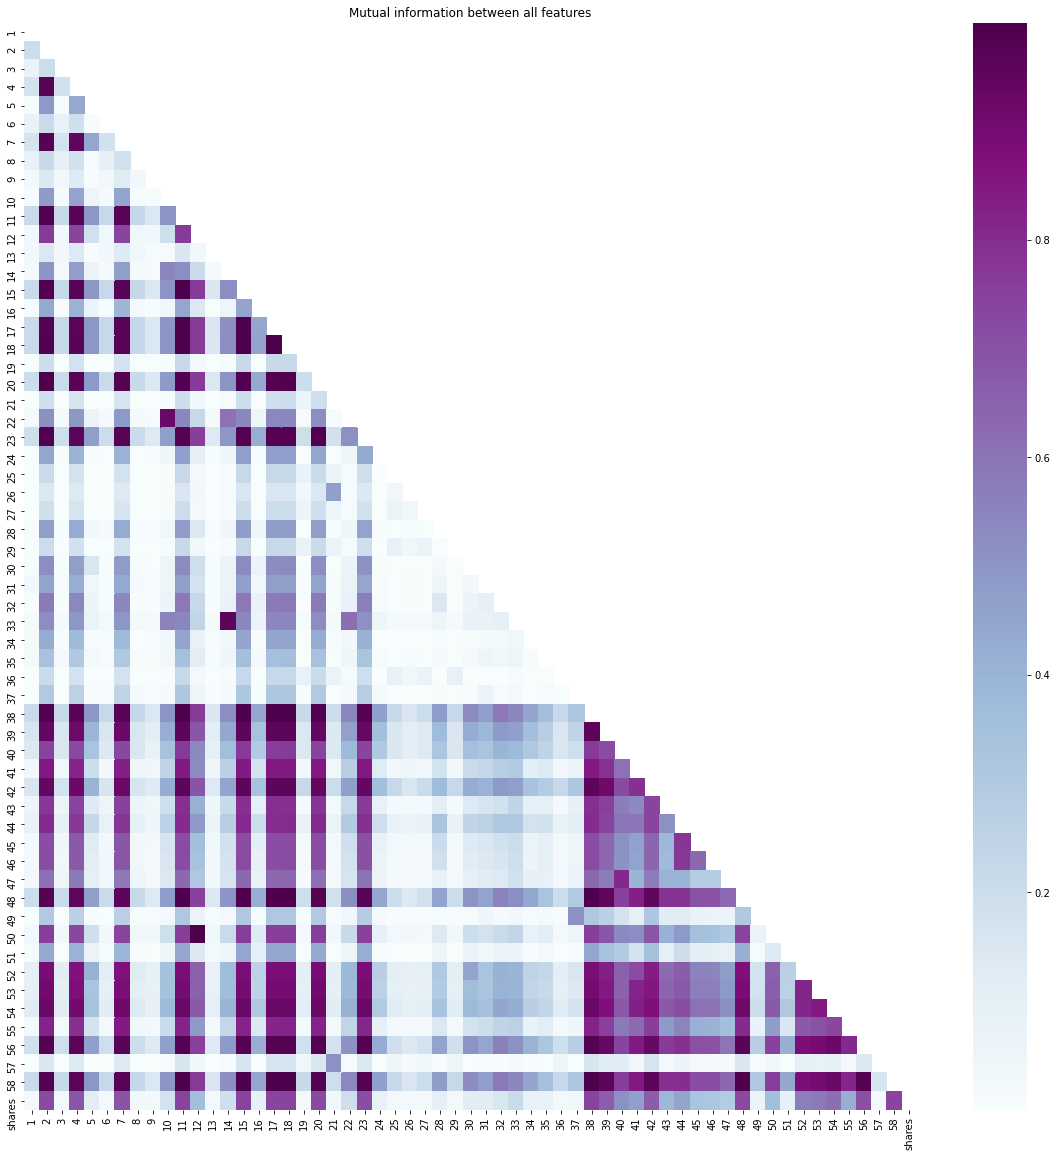

In [16]:
plt.figure(figsize=(20,20))
mask = np.triu(np.ones(mi_df.shape)).astype(np.bool)
sns.heatmap(np.abs(mi_df), mask=mask, cmap=CMAP).set_title("Mutual information between all features")
with output_dir(join(PLOTS_PATH, "feature_selection")) as path:
    plt.savefig(
        join(path, "mutual_information_features_num.png"),
        transparent=True
    )
    tiksave("mutual_information_features_num.tex")


# Mutual information between features and target

In [32]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from matplotlib import pyplot

fs_mi = SelectKBest(score_func=mutual_info_regression, k='all')
fs_mi.fit(X_train_num, y_train)

/home/romaingrx/anaconda3/envs/lelec2870/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x7f238a6a1310>)

array(['44', '42', '38', '40', '45', '46', '28', '15', '17', '58', '47',
       '34', '18', '21', '37', '52', '43', '11', '41', '8', '48', '3',
       '35', '39', '13', '26', '32', '2', '31', '7', '24', '50', '55',
       '16', '20', '54', '6', '12', '29', '19', '25', '4', '56', '5',
       '49', '30', '22', '1', '27', '9', '53', '51', '10', '14', '23',
       '33', '36', '57'], dtype='<U21')

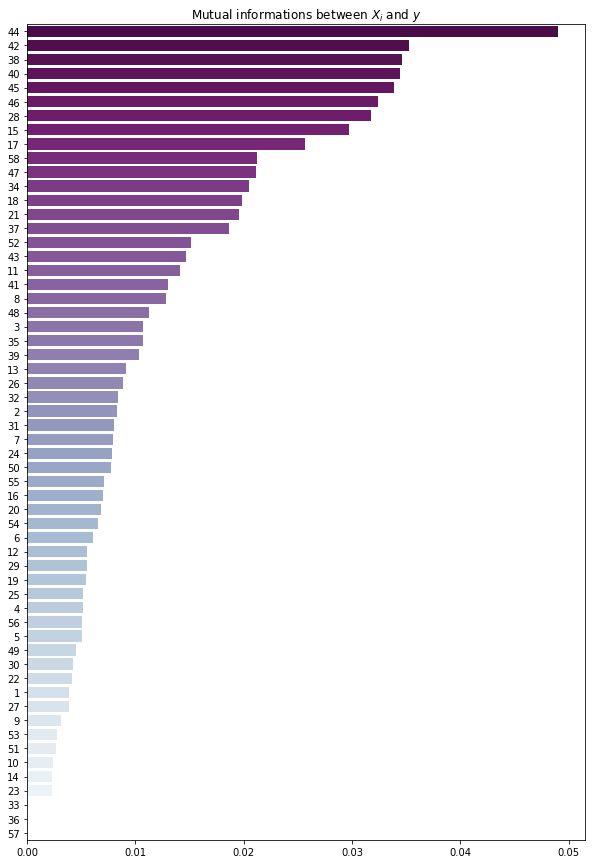

In [34]:
out, cols = bar(fs_mi.scores_, X_train_num.columns.values, "Mutual informations between $X_i$ and $y$", (10,15), get_cols=True)
fs_score_df = append_fs_score("mutual_information", fs_mi.scores_, X_train_num.columns.values)
with output_dir(join(PLOTS_PATH, "feature_selection")) as path:
    plt.savefig(
        join(path, "mutual_information_Xi_y_num.png"),
        transparent=True
    )
    tiksave("mutual_information_Xi_y_num.tex")

cols


# Lasso selection

array(['data_channel_is_bus', 'global_subjectivity',
       'data_channel_is_entertainment', 'avg_positive_polarity',
       'max_negative_polarity', 'data_channel_is_tech',
       'n_non_stop_unique_tokens', 'data_channel_is_world',
       'data_channel_is_lifestyle', 'abs_title_subjectivity', 'LDA_00',
       'rate_positive_words', 'data_channel_is_socmed',
       'abs_title_sentiment_polarity', 'LDA_02', 'max_positive_polarity',
       'LDA_01', 'LDA_04', 'weekday_is_monday',
       'global_sentiment_polarity', 'is_weekend', 'title_subjectivity',
       'average_token_length', 'n_tokens_title', 'weekday_is_thursday',
       'weekday_is_saturday', 'weekday_is_friday', 'num_self_hrefs',
       'weekday_is_tuesday', 'min_negative_polarity', 'num_imgs',
       'num_hrefs', 'title_sentiment_polarity', 'num_keywords',
       'num_videos', 'weekday_is_wednesday', 'kw_min_min', 'kw_avg_avg',
       'kw_avg_min', 'kw_min_avg', 'n_tokens_content', 'kw_max_avg',
       'kw_max_min', 'self_refe

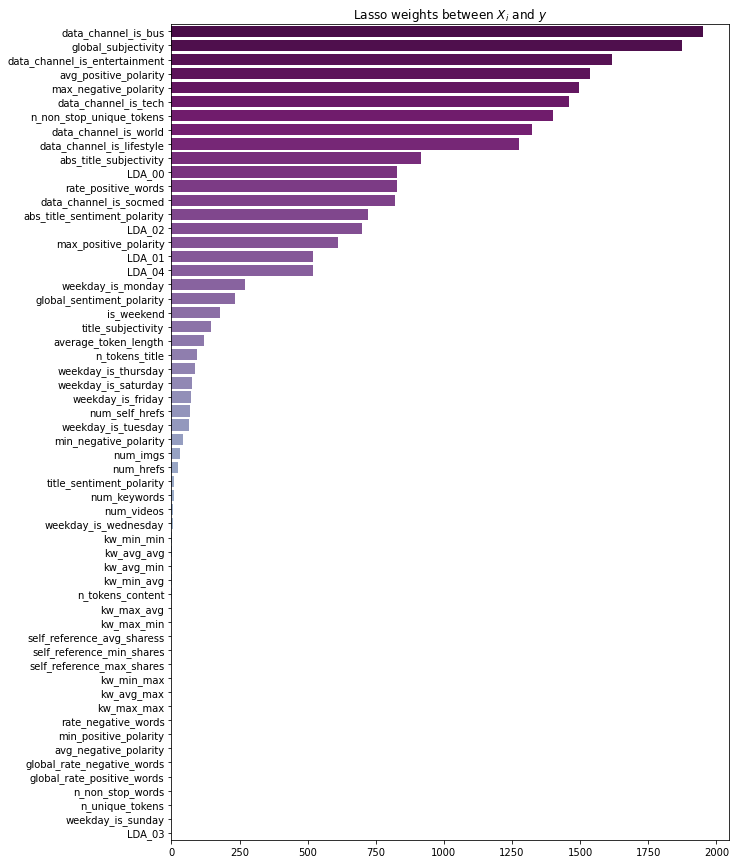

In [5]:
from sklearn.linear_model import Lasso

fs_lasso = Lasso()
fs_lasso.fit(X_train, y_train)

fig, cols = bar(np.abs(fs_lasso.coef_), X_train.columns.values, "Lasso weights between $X_i$ and $y$", (10,15), get_cols=True)

with output_dir(join(PLOTS_PATH, "feature_selection")) as path:
    plt.savefig(
        join(path, "lasso.png"),
        transparent=True
    )


fs_score_df = append_fs_score("lasso", np.abs(fs_lasso.coef_), X_train.columns.values)

score_regression(y_validation, fs_lasso.predict(X_validation))
cols




# Sequential feature selection

In [6]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lasso, Ridge

model = Ridge()

def scorer(estimator, X, y_true, **kwargs):
    y_hat = estimator.predict(X)
    score = score_regression(y_true, y_hat)
    return score

sfs_forward = SequentialFeatureSelector(
    model,
    k_features=len(X_train.columns),
    scoring=regression_scorer,
    forward=True,
    floating=False,
    cv=10,
    n_jobs=-1,
    verbose=0
)

sfs_forward.fit(X_train, y_train)

SequentialFeatureSelector(cv=10, estimator=Ridge(), k_features=58, n_jobs=-1,
                          scoring=<function regression_scorer at 0x7f14812e14c0>)

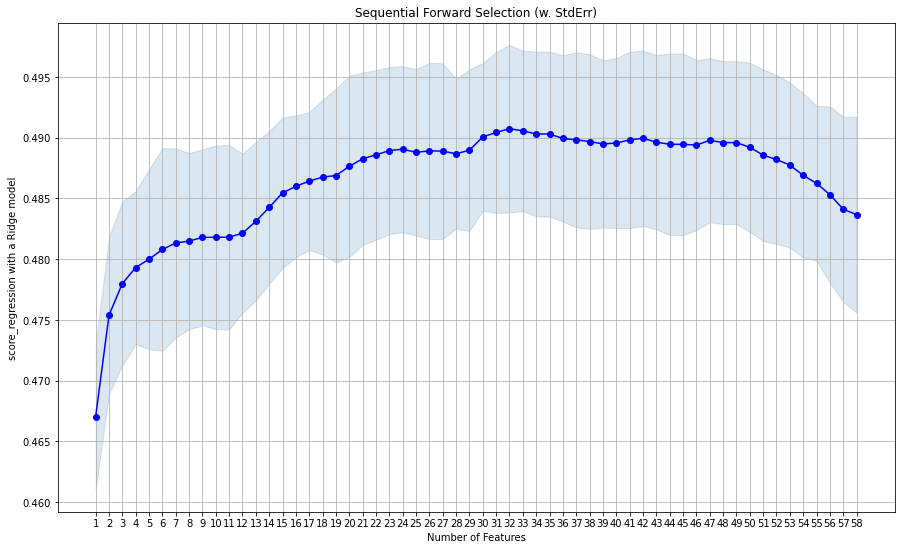

In [9]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
df_forward = pd.DataFrame(sfs_forward.get_metric_dict()).T
plot_sfs(sfs_forward.get_metric_dict(), kind='std_dev')

plt.gcf().set_size_inches(15,9)
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.ylabel("score_regression with a %s model"%model.__class__.__name__)
FORWARD_NAME = "sfs_forward_%s"%model.__class__.__name__
with output_dir(join(PLOTS_PATH, "feature_selection")) as path:
    plt.savefig(
        join(path,FORWARD_NAME+".png"),
        transparent=True
    )

with output_dir(join(CSV_PATH, "feature_selection")) as path:
    df_forward.to_csv(join(path, FORWARD_NAME+".csv"))

plt.show()


In [10]:
model = Ridge()

sfs_backward = SequentialFeatureSelector(
    model,
    k_features=1,
    scoring=regression_scorer,
    forward=False,
    floating=False,
    cv=10,
    n_jobs=-1,
    verbose=0
)

sfs_backward.fit(X_train, y_train)

SequentialFeatureSelector(cv=10, estimator=Ridge(), forward=False, n_jobs=-1,
                          scoring=<function regression_scorer at 0x7f14812e14c0>)

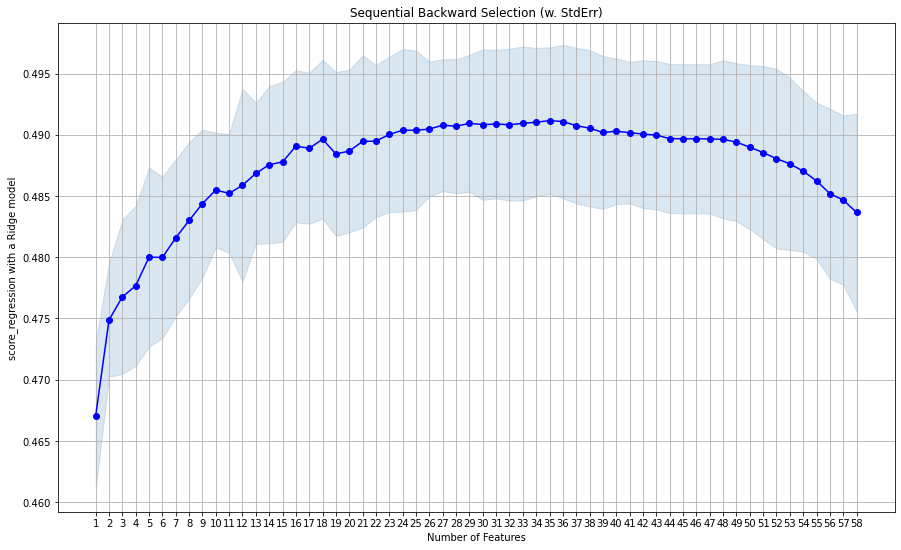

In [11]:
df_backward = pd.DataFrame(sfs_backward.get_metric_dict()).T
plot_sfs(sfs_backward.get_metric_dict(), kind='std_dev')

plt.gcf().set_size_inches(15,9)
plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.ylabel("score_regression with a %s model"%model.__class__.__name__)
BACKWARD_NAME = "sfs_backward_%s"%model.__class__.__name__
with output_dir(join(PLOTS_PATH, "feature_selection")) as path:
    plt.savefig(
        join(path,BACKWARD_NAME+".png"),
        transparent=True
    )

with output_dir(join(CSV_PATH, "feature_selection")) as path:
    df_backward.to_csv(join(path, BACKWARD_NAME+".csv"))

plt.show()

In [8]:
from pymrmre import mrmr

sols = dict()
for sl in (5, 10, 15, 20):
    sol = mrmr.mrmr_ensemble(X_train, y_train, solution_length=sl)
    sols[sl] = sol.values


sols

{5: array([list([['kw_avg_avg', 'data_channel_is_entertainment', 'weekday_is_tuesday', 'global_rate_positive_words', 'self_reference_min_shares']])],
       dtype=object),
 10: array([list([['kw_avg_avg', 'data_channel_is_entertainment', 'weekday_is_tuesday', 'global_rate_positive_words', 'self_reference_min_shares', 'num_hrefs', 'max_negative_polarity', 'weekday_is_saturday', 'abs_title_sentiment_polarity', 'data_channel_is_lifestyle']])],
       dtype=object),
 15: array([list([['kw_avg_avg', 'data_channel_is_entertainment', 'weekday_is_tuesday', 'global_rate_positive_words', 'self_reference_min_shares', 'num_hrefs', 'max_negative_polarity', 'weekday_is_saturday', 'abs_title_sentiment_polarity', 'data_channel_is_lifestyle', 'weekday_is_sunday', 'data_channel_is_socmed', 'global_rate_negative_words', 'kw_min_max', 'n_tokens_title']])],
       dtype=object),
 20: array([list([['kw_avg_avg', 'data_channel_is_entertainment', 'weekday_is_tuesday', 'global_rate_positive_words', 'self_refer